### The final version of the code, with additional global variables for visualization purposes, more accurate graph descriptions and more extensive comments may be found in `Open_Alex_Extraction_Final.ipynb`

In [1]:
from pyalex import Works, Authors, Sources, Institutions, Topics, Publishers, Funders, Concepts
import pandas as pd
import numpy as np
import urllib.parse
import re
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# !pip install pyalex # uncomment to install

In [3]:
# ANSI escape codes for colors
GREEN = '\033[92m'
RED = '\033[91m'
YELLOW = '\033[93m'
BLUE = '\033[94m'
RESET = '\033[0m'
MAGENTA = '\033[35m'
CYAN = '\033[36m'

## Reading (and sampling) the data

`biomedical_data.csv` is a subset of the original dataset containing publications __from the last 5 years__ and from __biomedical institutions only__ - amcpub, lumc, vumc, umcu. It contains 1856 records.

In [4]:
df = pd.read_csv("biomedical_data.csv")
sampled_df = df.sample(n=20, random_state=42)
# sampled_df = df

In [5]:
def author_title_pairs_lst(df):
    tuples_list = []                                             # create pairs (author, title) for each row of the df
    for index, row in df.iterrows():
        tuple_values = (row['author_name'], row['title'])
        tuples_list.append(tuple_values)
    return tuples_list

def contributors_lst(df):
    contributors_list = []                                       # create lists of contributors for each row of the df
    for index, row in df.iloc[:, 7:18].iterrows():
        contributors = []
        for value in row:
            if type(value) != float:
                contributors.append(value)
        contributors_list.append(contributors)
    return contributors_list

In [6]:
author_title_pairs = author_title_pairs_lst(sampled_df)
contributors_list = contributors_lst(sampled_df)

## Find the author

#### Get pubs from our df

In [7]:
def get_name(row):                                                     # needs a row of the pubs df
    author = author_title_pairs[row][0]
    if "," not in author:
        surname = author.split(" ")[0]
        initials = author.split(" ")[1].strip()
    else:
        surname = author.split(",")[0]
        initials = author.split(",")[1].strip()
    matched_initials = re.findall(r'\b[A-Z](?:\.[A-Z])\b', initials)   # adding space between initials if there is no
    if len(matched_initials)>0 and len(matched_initials[0])>2:         # essential transformation if authors cannot be matched
        initials_list = list(initials)                                 # with found title
        for initial in initials_list:
            if initial == ".":
                initials_list.remove(initial)
        name = ""
        for initial in initials_list:
            name += initial + ". "
        name += surname
    else:
        name = initials + " " + surname
    return name

def get_name_without_spaces(row):                                      # name as it is in the pubs df
    author = author_title_pairs[row][0]
    if "," not in author:
        surname = author.split(" ")[0]
        initials = author.split(" ")[1].strip()
    else:
        surname = author.split(",")[0]
        initials = author.split(",")[1].strip()
    name = initials + " " + surname
    return name

In [8]:
def title_transform(row):
    title = author_title_pairs[row][1]
    replace_dict = {'&': '', ',': ''}
    for k,v in replace_dict.items():
        title = title.replace(k,v)
    title = urllib.parse.quote(title)
    return title

#### Confirm the author

In [9]:
def confirm_author(row):                                                 # match to existing work, if not found, search by name

    author_id = ''

    try:
        query = Works().search_filter(title=title_transform(row)).get()

        if query == []:
            return "Title not matched"    # based on name

#         print(f'{len(query)} match(es) for the title found')
        for response in query:
            found = False
#             if response["authorships"] == []:
#                 print("No record of author for this title")
            for author in response["authorships"]:
                if author["author"]["display_name"] == get_name(row):    # first try matching on "raw" name
#                     print(MAGENTA + "Author found! - {}".format(get_name(row)) + RESET)
                    author_id = author["author"]["id"]
                    found = True
                if found == False:                                       # raw name matches based on the exact same string
                    q = Authors()[author["author"]["id"]]                # if not found check with ID
                    if (q["display_name"] == get_name(row) or get_name(row) in q["display_name_alternatives"]) or (q["display_name"] == get_name_without_spaces(row) or get_name_without_spaces(row) in q["display_name_alternatives"]):
#                         print(YELLOW + "Author found! - {}".format(get_name(row)) + RESET)
                        author_id = author["author"]["id"]
                        found = True
                    if (q["display_name"].lower() == get_name(row).lower() or q["display_name"].lower() == get_name_without_spaces(row).lower()):
#                         print(YELLOW + "Author found! - {}".format(get_name(row)) + RESET)
                        author_id = author["author"]["id"]
                        found = True
                    if q["display_name_alternatives"] != []:
                        for n in q["display_name_alternatives"]:
                            if (n.lower() == get_name(row).lower() or n.lower() == get_name_without_spaces(row).lower()):
#                                 print(YELLOW + "Author found! - {}".format(get_name(row)) + RESET)
                                author_id = author["author"]["id"]
                                found = True
#                     if found == False:
#                         print("Could not match {} to {}".format(get_name(row), q["display_name_alternatives"]))
                if found:
                    break
            if found:
                break


    except Exception as e:
        print("An unexpected error occurred:", e)


    if author_id != '':
        return author_id
    if author_id == None:
        return "Confirming author not successful"
    else:
        return "Confirming author not successful"

In [10]:
def title_DOI(row, confirmed_id):                                         # returns DOI of the title if the author is matched
                                                                          # based on that title
    DOIs = []

    if confirmed_id not in ["Confirming author not successful", "Title not matched"]:
        query = Works().search_filter(title=title_transform(row)).get()
        for response in query:
            DOIs.append(response["doi"])

    return DOIs

In [11]:
def get_author_id(row):                                                   # returns final author ID

    confirmed_id = confirm_author(row)

    if confirmed_id not in ["Confirming author not successful", "Title not matched"]:
        return confirmed_id

    query = Authors().search_filter(display_name=get_name(row)).get()

    if query == []:
        query = Authors().search_filter(display_name=get_name_without_spaces(row)).get()

    end_message = confirmed_id
    confirmed_id = ''

#     print("{} match(es) for the author found".format(len(query)))
    for response in query:
        found = False
        if (response["display_name"] == get_name(row) or get_name(row) in response["display_name_alternatives"]) or (response["display_name"] == get_name_without_spaces(row) or get_name_without_spaces(row) in response["display_name_alternatives"]):
#             print(BLUE + "Author found! - {}".format(get_name(row)) + RESET)
            confirmed_id = response["id"]
            found = True
        else:                                                               # many other cases ! - DOUBLE SURNAMES - NOT CLEAR WAY TO HANDLE (193 on rs 42)
            if get_name(row).lower() == response["display_name"].lower():
#                 print(CYAN + "Author found! - {}".format(get_name(row)) + RESET)
                confirmed_id = response["id"]
                found = True
            normalized_name1 = ' '.join(sorted(get_name(row).split()))
            normalized_name2 = ' '.join(sorted(response["display_name"].split()))
            if normalized_name1 == normalized_name2:
#                 print(CYAN + "Author found! - {}".format(get_name(row)) + RESET)
                confirmed_id = response["id"]
                found = True
        if found:
            break

    if confirmed_id != '':
        return confirmed_id
    else:
        return "Author (probably) not in Open Alex database"                 # OR AUTHOR NOT MATCHED !

Output colors:

__Magenta__ - author found in OpenAlex authors based on matched title

__Yellow__ - author found in OpenAlex authors based on matched title, for alternative version of author's name

__Blue__ - author found in OpenAlex authors

__Cyan__ - alternative version of author's name (likely the author) found in OpenAlex authors

## Get DOIs for the author

Not every work in Open Alex has a DOI, thus the returned list of DOIs may be shorter than the number of papers where the author was the first author. The DOI of the work that is already in pubs dataframe is also not included in the list - __only new DOIs are returned__.

In [12]:
def author_DOIs(row):

    author_id = get_author_id(row)
    if author_id == "Author (probably) not in Open Alex database":
#         print(RED + "Cannot be resolved" + RESET)
        return author_id
    initial_doi = title_DOI(row, author_id)

    result = Works().filter(authorships={"author": {"id": author_id}}).get()
#     print("Number of papers where the author was credited: {}".format(len(result)))

    DOIs = []

    i = 0
    for w in result:
        if w["authorships"][0]["author"]["id"] == author_id:
            i += 1
            if w["doi"] != None and w["doi"] not in initial_doi:
                DOIs.append(w["doi"])

#     print("Number of papers where the author was the first author: {}".format(i))

    if DOIs == []:
        return "No DOIs for the author found"
    else:
        return DOIs

## Get DOIs for the contributors

#### Transform contributors' names

In [13]:
def contributors_transformed(row):                                             # with space

    contributors = contributors_list[row]
    transformed_names = []

    for contribtor in contributors:
        surname = contribtor.split(",")[0]
        initials = contribtor.split(",")[1].strip()
        matched_initials = re.findall(r'\b[A-Z](?:\.[A-Z])\b', initials)
        if len(matched_initials)>0 and len(matched_initials[0])>2:
            initials_list = list(initials)
            for initial in initials_list:
                if initial == ".":
                    initials_list.remove(initial)
            name = ""
            for initial in initials_list:
                name += initial + ". "
            name += surname
        else:
            name = initials + " " + surname
        transformed_names.append(name)

    return transformed_names

def contributors_original(row):                                                # as originally in the data
                                                                               # will be used when the transformed names won't
    contributors = contributors_list[row]                                      # match
    transformed_names = []

    for contribtor in contributors:
        surname = contribtor.split(",")[0]
        initials = contribtor.split(",")[1].strip()
        name = initials + " " + surname
        transformed_names.append(name)

    return transformed_names

#### Find contributors (get IDs)

In [14]:
def get_contributors_ids(row):                                                 # returns a list of tuples of contributors and
                                                                               # their corresponding confirmed ids
    contributors = contributors_transformed(row)
    original_contributors = contributors_original(row)
    contributors_ids = []

    for contributor, og_contributor in zip(contributors, original_contributors):
#         print("Matching {}...".format(contributor))
        found = False
        response_list = []
        query = Authors().search_filter(display_name=contributor).get()        # 2 queries everytime could be too comp expens.
        if query == []:                                                        # check the difference?
            query = Authors().search_filter(display_name=og_contributor).get()
        if query == []:
#             print(RED + "        Cannot be resolved: " + RESET + "Could not find the author {}".format(contributor))
#         else:
#             print("        Found {} matches for {}".format(len(query), contributor))
            for i, response in enumerate(query):
#                 print("          {}:".format(i+1))
                if (response["display_name"] == contributor or contributor in response["display_name_alternatives"]) or (response["display_name"] == og_contributor or og_contributor in response["display_name_alternatives"]):
#                     print(BLUE + "            Contributor found! - {}".format(contributor) + RESET)
                    contributors_ids.append((contributor, response["id"]))
                    found = True
                else:
                    if contributor.lower() == response["display_name"].lower():
#                         print(CYAN + "            Contributor found! - {}".format(contributor) + RESET)
                        contributors_ids.append((contributor, response["id"]))
                        found = True
                if found == False:
                    if response["affiliations"] == []:
                        print(RED + "            No affiliations with institutions - unable to match" + RESET)
                    else:
                        for institution in response["affiliations"]:
                            if institution["institution"]["country_code"] == "NL":
#                                 print("            {} associated with {}, NL".format(response["display_name"], institution["institution"]["display_name"]))
#                                 print("            {} maybe associated with {}".format(contributor, response["display_name"]))
#                                 print(MAGENTA + "            Requires manual check to confirm" + RESET)
                                if ("MANUAL CHECK: if {} (target) is {} (found)".format(contributor, response["display_name"]), response["id"]) not in contributors_ids:
                                    response_list.append(("MANUAL CHECK: if {} (target) is {} (found)".format(contributor, response["display_name"]), response["id"]))
#                             else:
#                                 print(RED + "            No NL institution - unlikely to be the match" + RESET)
                if found:
                    break
                if i == len(query)-1:
                    contributors_ids.extend(response_list)

    if contributors_ids == []:
        return "None of the contributors is in Open Alex database"
    else:
        return contributors_ids

### Get DOIs

In [15]:
def contributors_DOIs(row):

    ids_list = get_contributors_ids(row)
    confirmed = []
    manual_check = []

    for pair in ids_list:
        if "MANUAL CHECK" in pair[0]:
            if pair not in manual_check:
                manual_check.append(pair)
        else:
            confirmed.append(pair)

    if ids_list == "None of the contributors is in Open Alex database":
        return ids_list


    DOIs_dict = {}

    for author in confirmed:
        author_id = author[1]
        result = Works().filter(authorships={"author": {"id": author_id}}).get()
#         print()
#         print("Searching works for {}...".format(author[0]))
#         print("        Number of papers where the contributor was credited as an author: {}".format(len(result)))

        DOIs = []

        i = 0
        for w in result:
            if w["authorships"][0]["author"]["id"] == author_id:
                i += 1
                if w["doi"] != None:
                    DOIs.append(w["doi"])

#         print("        Number of papers where the contributor was the first author: {}".format(i))

        if author[0] not in DOIs_dict:
            DOIs_dict[author[0]] = DOIs

    for author in manual_check:
        author_id = author[1]
        extract_name = re.search(r'if\s+(.*?)\s+is', author[0])
        name = extract_name.group(1)
        result = Works().filter(authorships={"author": {"id": author_id}}).get()
#         print()
#         print("Searching works for {}... - NOT CONFIRMED".format(name))
#         print("        Number of papers where the contributor was credited as an author: {}".format(len(result)))

        DOIs = []

        i = 0
        for w in result:
            if w["authorships"][0]["author"]["id"] == author_id:
                i += 1
                if w["doi"] != None:
                    DOIs.append(w["doi"])

        print("        Number of papers where the contributor was the first author: {}".format(i))

        name = name + " - NOT CONFIRMED"
        if name not in DOIs_dict:
            DOIs_dict[name] = DOIs


    if DOIs_dict == {}:
        return "No DOIs for the associated contributors found"

    got_dois = False
    for value in DOIs_dict.values():
        if value != []:
            got_dois = True
    if got_dois:
        return DOIs_dict
    else:
        return "No DOIs for the associated contributors found"

## Run on a subset

Store the output in `dois_df`

In [16]:
dois_data = []

for i in tqdm(range(len(sampled_df))):
    contributors = contributors_DOIs(i)
    if contributors == "None of the contributors is in Open Alex database" or contributors == "No DOIs for the associated contributors found":
        message_contributors = contributors
        contributors = np.nan
        contr_count = 0
        contr_dois_count = 0
    else:
        contr_count = sum(1 for lst in contributors.values() if lst)
        contr_dois_count = sum(len(lst) for lst in contributors.values())
        message_contributors = np.nan

    author_dois = author_DOIs(i)
    if author_dois == "Author (probably) not in Open Alex database" or author_dois == "No DOIs for the author found":
        message_author = author_dois
        author_dois = np.nan
        count = 0
    else:
        count = len(author_dois)
        message_author = np.nan

    data = {'Author': get_name_without_spaces(i), 'Author DOIs found in OpenAlex': author_dois, 'DOIs count': count, 'Contributors-DOIs Dictionary': contributors, 'Number of contributors with DOIs found in OpenAlex': contr_count, 'Cumulative found Contributor DOIs count': contr_dois_count, 'Why no DOIs for author': message_author, 'Why no DOIs for contributors': message_contributors}
    dois_data.append(data)

dois_df = pd.DataFrame(dois_data)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:53<00:00, 11.70s/it]


In [18]:
dois_df = pd.DataFrame(dois_data)
dois_df

,Author,Author DOIs found in OpenAlex,DOIs count,Contributors-DOIs Dictionary,Number of contributors with DOIs found in OpenAlex,Cumulative found Contributor DOIs count,Why no DOIs for author,Why no DOIs for contributors
0,Maxime D. Slooter,"[https://doi.org/10.21037/jtd.2019.01.30, http...",13,NaN,0,0,NaN,None of the contributors is in Open Alex database
1,Patricia van Velzen,[https://doi.org/10.1016/s2213-2600(17)30165-0...,5,NaN,0,0,NaN,None of the contributors is in Open Alex database
2,Teele Kuusk,"[https://doi.org/10.1186/s12894-015-0118-2, ht...",4,NaN,0,0,NaN,None of the contributors is in Open Alex database
3,Floor Groepenhoff,"[https://doi.org/10.1186/s12880-020-00535-7, h...",8,NaN,0,0,NaN,None of the contributors is in Open Alex database
4,Michiel A. J. Luijten,"[https://doi.org/10.1007/s11136-021-02861-x, h...",7,NaN,0,0,NaN,None of the contributors is in Open Alex database
5,Evelyne Jeannette Demkes,"[https://doi.org/10.3389/fphar.2021.702326, ht...",2,NaN,0,0,NaN,None of the contributors is in Open Alex database
6,A. Zweerink,[https://doi.org/10.1161/circheartfailure.118....,13,NaN,0,0,NaN,None of the contributors is in Open Alex database
7,Casper Thomas Briels,NaN,0,NaN,0,0,Author (probably) not in Open Alex database,None of the contributors is in Open Alex database
8,Jiayi Pei,"[https://doi.org/10.1186/s13148-021-01043-3, h...",6,NaN,0,0,NaN,None of the contributors is in Open Alex database
9,Sander Brinkhof,"[https://doi.org/10.1007/s00330-017-5277-y, ht...",7,NaN,0,0,NaN,None of the contributors is in Open Alex database


## Visualisations & Statistics

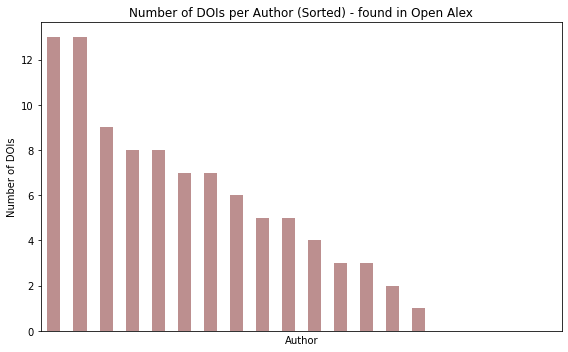

In [19]:
author_doi_counts = dois_df.groupby('Author')['DOIs count'].sum()

author_doi_counts = author_doi_counts.sort_values(ascending=False)

plt.figure(figsize=(8, 5))
author_doi_counts.plot(kind='bar', color='rosybrown')
plt.title('Number of DOIs per Author (Sorted) - found in Open Alex')
plt.ylabel('Number of DOIs')
plt.locator_params(axis='y', integer=True)
plt.xticks([])
plt.tight_layout()
plt.show()

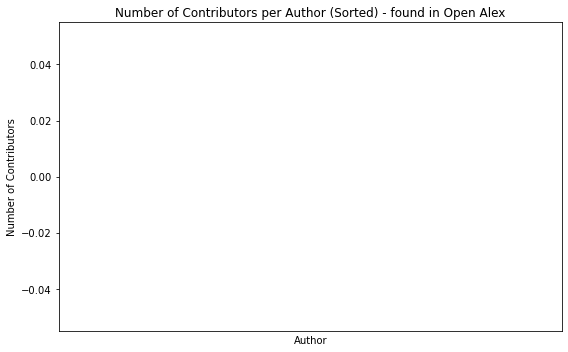

In [20]:
author_contributors_count = dois_df.groupby('Author')['Number of contributors with DOIs found in OpenAlex'].sum()

author_contributors_count = author_contributors_count.sort_values(ascending=False)

plt.figure(figsize=(8, 5))
author_contributors_count.plot(kind='bar', color='pink')
plt.title('Number of Contributors per Author (Sorted) - found in Open Alex')
plt.ylabel('Number of Contributors')
plt.locator_params(axis='y', integer=True)
plt.xticks([])
plt.tight_layout()
plt.show()

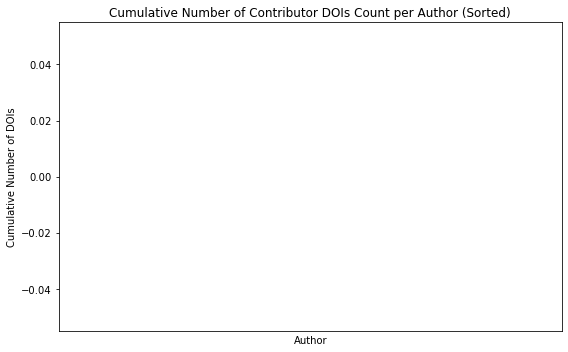

In [21]:
author_cumulative_dois_count = dois_df.groupby('Author')['Cumulative found Contributor DOIs count'].sum()

author_cumulative_dois_count = author_cumulative_dois_count.sort_values(ascending=False)

plt.figure(figsize=(8, 5))
author_cumulative_dois_count.plot(kind='bar', color='tan')
plt.title('Cumulative Number of Contributor DOIs Count per Author (Sorted)')
plt.ylabel('Cumulative Number of DOIs')

plt.locator_params(axis='y', integer=True)

plt.xticks([])
plt.tight_layout()
plt.show()

In [22]:
mean_dois_per_author = dois_df['DOIs count'].mean()
median_dois_per_author = dois_df['DOIs count'].median()

mean_found_contributors = dois_df['Number of contributors with DOIs found in OpenAlex'].mean()
median_found_contributors = dois_df['Number of contributors with DOIs found in OpenAlex'].median()

mean_cumulative_dois_count = dois_df['Cumulative found Contributor DOIs count'].mean()
median_cumulative_dois_count = dois_df['Cumulative found Contributor DOIs count'].median()

nan_author_dois_count = dois_df['Author DOIs found in OpenAlex'].isnull().sum()
nan_contributors_dois_count = dois_df['Contributors-DOIs Dictionary'].isnull().sum()

summary_data = {
    'Statistics': ['Mean DOIs per Author', 'Median DOIs per Author',
                   'Mean Found Contributors', 'Median Found Contributors',
                   'Mean Cumulative DOIs Count', 'Median Cumulative DOIs Count',
                   'NaN Values for Author DOIs', 'NaN Values for Contributors DOIs'],
    'Values': [mean_dois_per_author, median_dois_per_author,                           # round if needed
               mean_found_contributors, median_found_contributors,
               mean_cumulative_dois_count, median_cumulative_dois_count,
               nan_author_dois_count, nan_contributors_dois_count]
}

summary_df = pd.DataFrame(summary_data)

summary_df

,Statistics,Values
0,Mean DOIs per Author,4.7
1,Median DOIs per Author,4.5
2,Mean Found Contributors,0.0
3,Median Found Contributors,0.0
4,Mean Cumulative DOIs Count,0.0
5,Median Cumulative DOIs Count,0.0
6,NaN Values for Author DOIs,5.0
7,NaN Values for Contributors DOIs,20.0


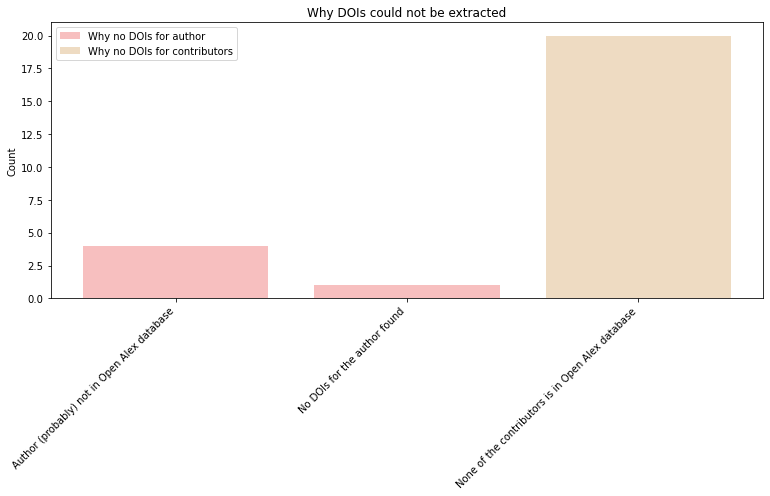

In [23]:
dois_df.fillna('Unknown', inplace=True)

unique_messages_column1 = dois_df['Why no DOIs for author'].value_counts()
unique_messages_column2 = dois_df['Why no DOIs for contributors'].value_counts()

unique_messages_column1 = unique_messages_column1.drop('Unknown', errors='ignore')
unique_messages_column2 = unique_messages_column2.drop('Unknown', errors='ignore')

plt.figure(figsize=(11, 7))

plt.bar(unique_messages_column1.index, unique_messages_column1.values, alpha=0.5, label='Why no DOIs for author', color='lightcoral')
plt.bar(unique_messages_column2.index, unique_messages_column2.values, alpha=0.5, label='Why no DOIs for contributors', color='burlywood')

plt.ylabel('Count')
plt.title('Why DOIs could not be extracted')
plt.xticks(rotation=45, ha='right')
plt.legend()

plt.tight_layout()
plt.show()

### Filter for the task at hand

In [24]:
df_clean = dois_df.iloc[:, :6].dropna()
# df_clean.reset_index(drop=True, inplace=True)
df_clean

,Author,Author DOIs found in OpenAlex,DOIs count,Contributors-DOIs Dictionary,Number of contributors with DOIs found in OpenAlex,Cumulative found Contributor DOIs count
0,Maxime D. Slooter,"[https://doi.org/10.21037/jtd.2019.01.30, http...",13,Unknown,0,0
1,Patricia van Velzen,[https://doi.org/10.1016/s2213-2600(17)30165-0...,5,Unknown,0,0
2,Teele Kuusk,"[https://doi.org/10.1186/s12894-015-0118-2, ht...",4,Unknown,0,0
3,Floor Groepenhoff,"[https://doi.org/10.1186/s12880-020-00535-7, h...",8,Unknown,0,0
4,Michiel A. J. Luijten,"[https://doi.org/10.1007/s11136-021-02861-x, h...",7,Unknown,0,0
5,Evelyne Jeannette Demkes,"[https://doi.org/10.3389/fphar.2021.702326, ht...",2,Unknown,0,0
6,A. Zweerink,[https://doi.org/10.1161/circheartfailure.118....,13,Unknown,0,0
7,Casper Thomas Briels,Unknown,0,Unknown,0,0
8,Jiayi Pei,"[https://doi.org/10.1186/s13148-021-01043-3, h...",6,Unknown,0,0
9,Sander Brinkhof,"[https://doi.org/10.1007/s00330-017-5277-y, ht...",7,Unknown,0,0


In [25]:
mean_dois_per_author = df_clean['DOIs count'].mean()
median_dois_per_author = df_clean['DOIs count'].median()

mean_found_contributors = df_clean['Number of contributors with DOIs found in OpenAlex'].mean()
median_found_contributors = df_clean['Number of contributors with DOIs found in OpenAlex'].median()

mean_cumulative_dois_count = df_clean['Cumulative found Contributor DOIs count'].mean()
median_cumulative_dois_count = df_clean['Cumulative found Contributor DOIs count'].median()

summary_data = {
    'Statistics': ['Mean DOIs per Author', 'Median DOIs per Author',
                   'Mean Found Contributors', 'Median Found Contributors',
                   'Mean Cumulative DOIs Count', 'Median Cumulative DOIs Count'],
    'Values': [mean_dois_per_author, median_dois_per_author,
               mean_found_contributors, median_found_contributors,
               mean_cumulative_dois_count, median_cumulative_dois_count]
}

summary_df = pd.DataFrame(summary_data)

summary_df

,Statistics,Values
0,Mean DOIs per Author,4.7
1,Median DOIs per Author,4.5
2,Mean Found Contributors,0.0
3,Median Found Contributors,0.0
4,Mean Cumulative DOIs Count,0.0
5,Median Cumulative DOIs Count,0.0


In [26]:
# df_clean.to_csv('complete_extraction.csv', index=False) # x - nr of rows